In [ ]:
# Standard library
import os
import random
import shutil
import sys
from collections import Counter

# Core third‑party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
from tqdm import tqdm

# Sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedGroupKFold, train_test_split

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader

# torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torchvision.utils
from torchvision import datasets, models, transforms

# Third‑party libraries
import timm
import ttach as tta
from focal_loss.focal_loss import FocalLoss

# Misc cleanup / garbage collection
import gc

# Enable inline plots (in Jupyter environments)
%matplotlib inline


# Preprocessing

In [ ]:
# =======================
# 1) Device & Seed Setup
# =======================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# =================
# 2) Data Paths
# =================

data_dir           = './content/drive/My Drive/ens492'
train_dir          = './content/train_dataset/ISIC_2019_Training_Input'
test_dir           = './content/test_dataset/ISIC_2019_Test_Input'
train_truth_file   = 'ISIC_2019_Training_GroundTruth.csv'
test_truth_file    = 'ISIC_2019_Test_GroundTruth.csv'

# =============================
# 3) Load & Process GroundTruth
# =============================

train_gt = pd.read_csv(os.path.join(data_dir, train_truth_file))
test_gt  = pd.read_csv(os.path.join(data_dir, test_truth_file))

# Create single_label for training (exclude image & UNK)
train_labels = train_gt.iloc[:, 1:9]
train_gt['single_label'] = train_labels.values.argmax(axis=1)

# For test (include UNK)
test_labels = test_gt.iloc[:, 1:10]
test_gt['single_label'] = test_labels.values.argmax(axis=1)

# ============================
# 4) Stratified Train/Val Split
# ============================

train_gt['patient_id'] = train_gt['image']
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)
train_idx, val_idx = next(sgkf.split(train_gt, train_gt['single_label'], groups=train_gt['patient_id']))

train_df = train_gt.iloc[train_idx].reset_index(drop=True).drop(columns=['patient_id'])
val_df   = train_gt.iloc[val_idx].reset_index(drop=True).drop(columns=['patient_id'])

# ======================
# 5) Transforms & Augs
# ======================

class CircularMask:
    def __call__(self, img):
        w, h = img.size
        mask = Image.new('L', (w, h), 0)
        draw = ImageDraw.Draw(mask)
        r = min(w, h)//2
        draw.ellipse((w//2-r, h//2-r, w//2+r, h//2+r), fill=255)
        img_rgba = img.convert('RGBA')
        black_bg = Image.new('RGBA', (w,h), (0,0,0,255))
        comp = Image.composite(img_rgba, black_bg, mask)
        return comp.convert('RGB')

class CenterSquareCrop:
    def __call__(self, img):
        w, h = img.size
        m = min(w, h)
        left, top = (w-m)//2, (h-m)//2
        return img.crop((left, top, left+m, top+m))

train_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.RandomRotation(45),
    CenterSquareCrop(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=0.5, translate=(0.1,0.1), scale=(1.0,1.05), fill=(200,200,200))
    ], p=0.5),
    transforms.ColorJitter(0.2,0.2),
    transforms.Resize((456,456)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    CenterSquareCrop(),
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((456,456)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# =====================
# 6) Dataset Class
# =====================

class ISICDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name = self.df.iloc[idx]['image'] + '.jpg'
        img = Image.open(os.path.join(self.img_dir, name))
        label = int(self.df.iloc[idx]['single_label'])
        if self.transform:
            img = self.transform(img)
        return img, label

# =====================
# 7) DataLoaders
# =====================

BATCH_SIZE = 32  # adjust for 456x456
train_ds = ISICDataset(train_df, train_dir, train_transform)
val_ds   = ISICDataset(val_df,   train_dir, val_transform)
test_ds  = ISICDataset(test_gt,  test_dir,  val_transform, is_test=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,num_workers=8, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,num_workers=8, pin_memory=True)

## Augmentation Results:

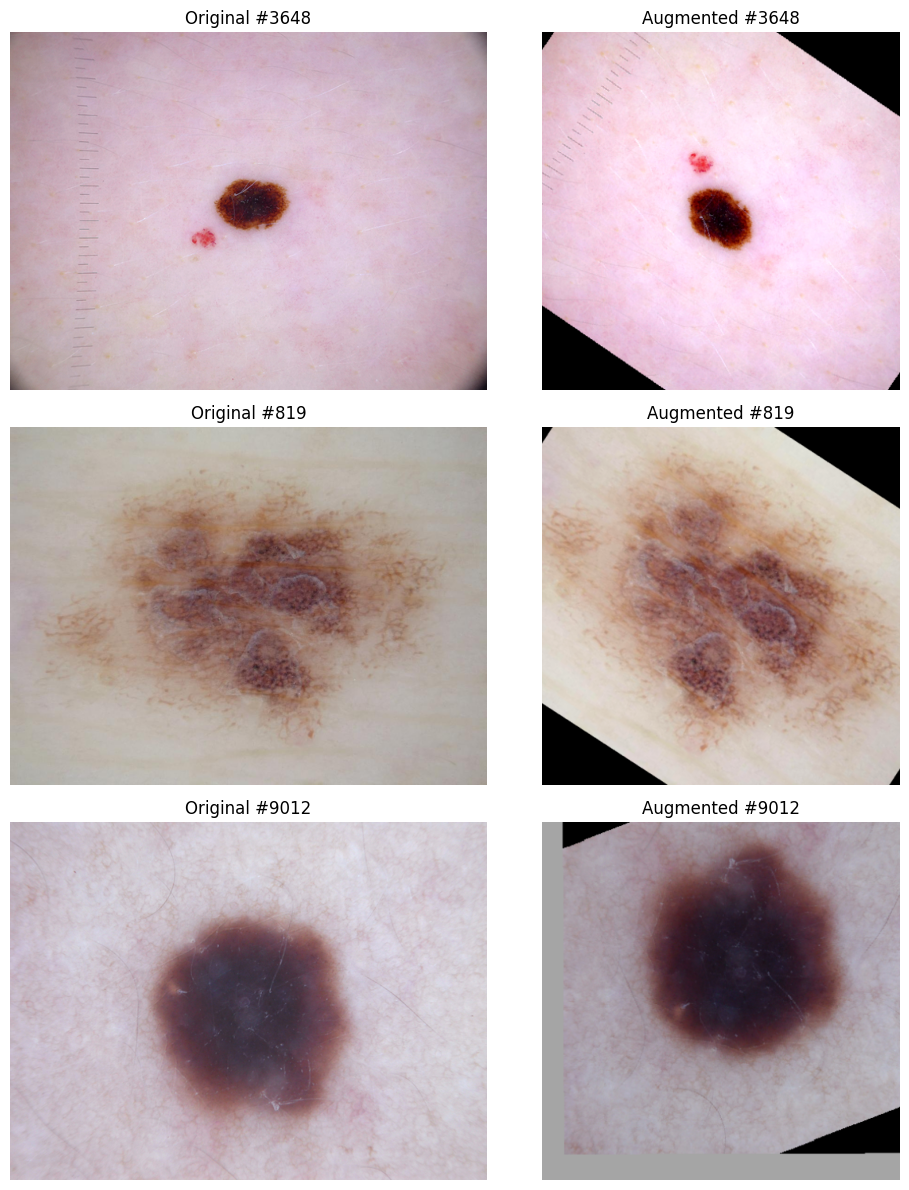

In [ ]:
# Helper to undo normalization
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    return torch.clamp(tensor * std[:, None, None] + mean[:, None, None], 0, 1)

# Pick 3 random indices from the train_df
sample_indices = random.sample(range(len(train_df)), 3)

# Create figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

for row, idx in enumerate(sample_indices):
    img_name = train_df.iloc[idx]['image'] + '.jpg'
    img_path = os.path.join(train_dir, img_name)

    # Load original
    original_image = Image.open(img_path).convert("RGB")

    # Augmented version
    augmented_tensor = train_transform(original_image)
    augmented_image = denormalize(augmented_tensor)
    augmented_image = TF.to_pil_image(augmented_image)

    # Plot original
    axes[row, 0].imshow(original_image)
    axes[row, 0].set_title(f'Original #{idx}')
    axes[row, 0].axis('off')

    # Plot augmented
    axes[row, 1].imshow(augmented_image)
    axes[row, 1].set_title(f'Augmented #{idx}')
    axes[row, 1].axis('off')

plt.tight_layout()
plt.show()


## Training Routine

In [ ]:
# Python’s garbage collector
gc.collect()

# Empty PyTorch’s CUDA cache
torch.cuda.empty_cache()


# === Model & Training Setup ===
num_classes = 8
gamma = 2.41473018656194
wd = 0.00859853538142981
base_lr = 0.0000839850015566498
num_epochs = 25

model = timm.create_model('efficientnet_b5', pretrained=True, num_classes=8)
model = model.to(device)

criterion = FocalLoss(gamma=gamma, reduction='mean')

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=wd)

# Mixed Precision
scaler = GradScaler()

# === Train Function ===
def train_one_epoch(model, dataloader, optimizer):
    model.train()
    correct, total = 0, 0
    total_loss = 0.0  # Track total loss for the epoch

    for inputs, targets in tqdm(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            outputs = torch.softmax(outputs, dim=1)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * targets.size(0)  # accumulate total loss

        with torch.no_grad():
            _, predicted = torch.max(outputs, 1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    avg_loss = total_loss / total  # Calculate average loss for the epoch
    return 100. * correct / total, avg_loss  # Return accuracy and average loss

# === Evaluate Function ===
def evaluate(model, dataloader, criterion, is_test=False):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels, all_probs = [], [], []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=-1)
            loss = criterion(probs, targets)
            total_loss += loss.item() * targets.size(0)

            if is_test:
                max_probs, predicted = probs.max(1)
                unk_probs = 1 - max_probs
                predicted = torch.where(unk_probs > 0.5,
                                        torch.tensor(num_classes-1).to(device),
                                        predicted)
            else:
                _, predicted = probs.max(1)

            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    avg_loss = total_loss / total
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    acc = 100. * correct / total
    return acc, avg_loss, macro_f1, all_preds, all_labels, all_probs

# === Dataloaders ===
#test_dataset = ISICDataset(test_ground_truth_df, test_dir, val_transform)
#test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# === Training Loop ===
best_val_f1 = 0
best_val_loss = float('inf')  # Start with infinity for the best validation loss

# Tracking metrics
train_accs, val_accs, train_losses, val_losses, val_f1s = [], [], [], [], []

print("Starting training...")

for epoch in range(num_epochs):
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    train_acc, train_loss = train_one_epoch(model, train_loader, optimizer)
    val_acc, val_loss, val_f1, val_preds, val_labels, val_probs = evaluate(model, val_loader, criterion)

    # Log metrics
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    print(f'Train Accuracy      : {train_acc:.2f}%')
    print(f'Validation Accuracy : {val_acc:.2f}%')
    print(f'Train Loss          : {train_loss:.4f}')
    print(f'Validation Loss     : {val_loss:.4f}')
    print(f'Validation Macro F1 : {val_f1:.4f}')

    """
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_vit_model.pth')
        print(f'✅ Model saved! Best Macro F1: {best_val_f1:.4f}')
    """

    # Save the best model based on lowest validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_vit_model_lowest_loss.pth')
        print(f'✅ Model saved! Best Validation Loss: {best_val_loss:.4f}')

/tmp/ipykernel_1789062/3740013748.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Starting training...

Epoch [1/25]


  0%|                                                   | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_1789062/3740013748.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|█████████████████████████████████████████| 634/634 [03:46<00:00,  2.80it/s]


Train Accuracy      : 69.19%
Validation Accuracy : 75.44%
Train Loss          : 0.5035
Validation Loss     : 0.2875
Validation Macro F1 : 0.5756
✅ Model saved! Best Validation Loss: 0.2875

Epoch [2/25]


  0%|                                                   | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_1789062/3740013748.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|█████████████████████████████████████████| 634/634 [03:46<00:00,  2.79it/s]


Train Accuracy      : 79.46%
Validation Accuracy : 79.51%
Train Loss          : 0.2430
Validation Loss     : 0.2590
Validation Macro F1 : 0.6550
✅ Model saved! Best Validation Loss: 0.2590

Epoch [3/25]


  0%|                                                   | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_1789062/3740013748.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|█████████████████████████████████████████| 634/634 [03:46<00:00,  2.80it/s]


Train Accuracy      : 82.66%
Validation Accuracy : 82.02%
Train Loss          : 0.1820
Validation Loss     : 0.2266
Validation Macro F1 : 0.6936
✅ Model saved! Best Validation Loss: 0.2266

Epoch [4/25]


  0%|                                                   | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_1789062/3740013748.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|█████████████████████████████████████████| 634/634 [03:46<00:00,  2.80it/s]


Train Accuracy      : 85.33%
Validation Accuracy : 82.12%
Train Loss          : 0.1447
Validation Loss     : 0.2054
Validation Macro F1 : 0.7149
✅ Model saved! Best Validation Loss: 0.2054

Epoch [5/25]


  0%|                                                   | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_1789062/3740013748.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|█████████████████████████████████████████| 634/634 [03:46<00:00,  2.80it/s]


Train Accuracy      : 87.75%
Validation Accuracy : 83.97%
Train Loss          : 0.1138
Validation Loss     : 0.1832
Validation Macro F1 : 0.7806
✅ Model saved! Best Validation Loss: 0.1832

Epoch [6/25]


  0%|                                                   | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_1789062/3740013748.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|█████████████████████████████████████████| 634/634 [03:46<00:00,  2.80it/s]


Train Accuracy      : 88.93%
Validation Accuracy : 85.61%
Train Loss          : 0.0992
Validation Loss     : 0.1669
Validation Macro F1 : 0.7931
✅ Model saved! Best Validation Loss: 0.1669

Epoch [7/25]


  0%|                                                   | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_1789062/3740013748.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|█████████████████████████████████████████| 634/634 [03:46<00:00,  2.80it/s]


Train Accuracy      : 90.50%
Validation Accuracy : 85.59%
Train Loss          : 0.0797
Validation Loss     : 0.1819
Validation Macro F1 : 0.7896

Epoch [8/25]


  0%|                                                   | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_1789062/3740013748.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|█████████████████████████████████████████| 634/634 [03:46<00:00,  2.80it/s]


Train Accuracy      : 91.17%
Validation Accuracy : 84.56%
Train Loss          : 0.0747
Validation Loss     : 0.1853
Validation Macro F1 : 0.7554

Epoch [9/25]


  0%|                                                   | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_1789062/3740013748.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|█████████████████████████████████████████| 634/634 [03:44<00:00,  2.82it/s]


Train Accuracy      : 91.86%
Validation Accuracy : 85.77%
Train Loss          : 0.0664
Validation Loss     : 0.1836
Validation Macro F1 : 0.7960

Epoch [10/25]


  0%|                                                   | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_1789062/3740013748.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|█████████████████████████████████████████| 634/634 [03:46<00:00,  2.80it/s]


Train Accuracy      : 92.95%
Validation Accuracy : 86.12%
Train Loss          : 0.0568
Validation Loss     : 0.1835
Validation Macro F1 : 0.7985

Epoch [11/25]


  0%|                                                   | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_1789062/3740013748.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|█████████████████████████████████████████| 634/634 [03:45<00:00,  2.81it/s]


Train Accuracy      : 93.70%
Validation Accuracy : 87.78%
Train Loss          : 0.0527
Validation Loss     : 0.1684
Validation Macro F1 : 0.8252

Epoch [12/25]


  0%|                                                   | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_1789062/3740013748.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|█████████████████████████████████████████| 634/634 [03:46<00:00,  2.80it/s]


Train Accuracy      : 93.66%
Validation Accuracy : 86.85%
Train Loss          : 0.0525
Validation Loss     : 0.1905
Validation Macro F1 : 0.7990

Epoch [13/25]


  0%|                                                   | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_1789062/3740013748.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|█████████████████████████████████████████| 634/634 [03:45<00:00,  2.81it/s]


Train Accuracy      : 94.75%
Validation Accuracy : 85.98%
Train Loss          : 0.0438
Validation Loss     : 0.1740
Validation Macro F1 : 0.8123

Epoch [14/25]


  0%|                                                   | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_1789062/3740013748.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|█████████████████████████████████████████| 634/634 [03:46<00:00,  2.80it/s]


Train Accuracy      : 94.62%
Validation Accuracy : 87.09%
Train Loss          : 0.0428
Validation Loss     : 0.1841
Validation Macro F1 : 0.8188

Epoch [15/25]


  0%|                                                   | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_1789062/3740013748.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|█████████████████████████████████████████| 634/634 [03:45<00:00,  2.82it/s]


Train Accuracy      : 95.05%
Validation Accuracy : 86.46%
Train Loss          : 0.0390
Validation Loss     : 0.1869
Validation Macro F1 : 0.8092

Epoch [16/25]


  0%|                                                   | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_1789062/3740013748.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 79%|████████████████████████████████▍        | 501/634 [03:00<00:47,  2.78it/s]


KeyboardInterrupt: 

## Training Plots:

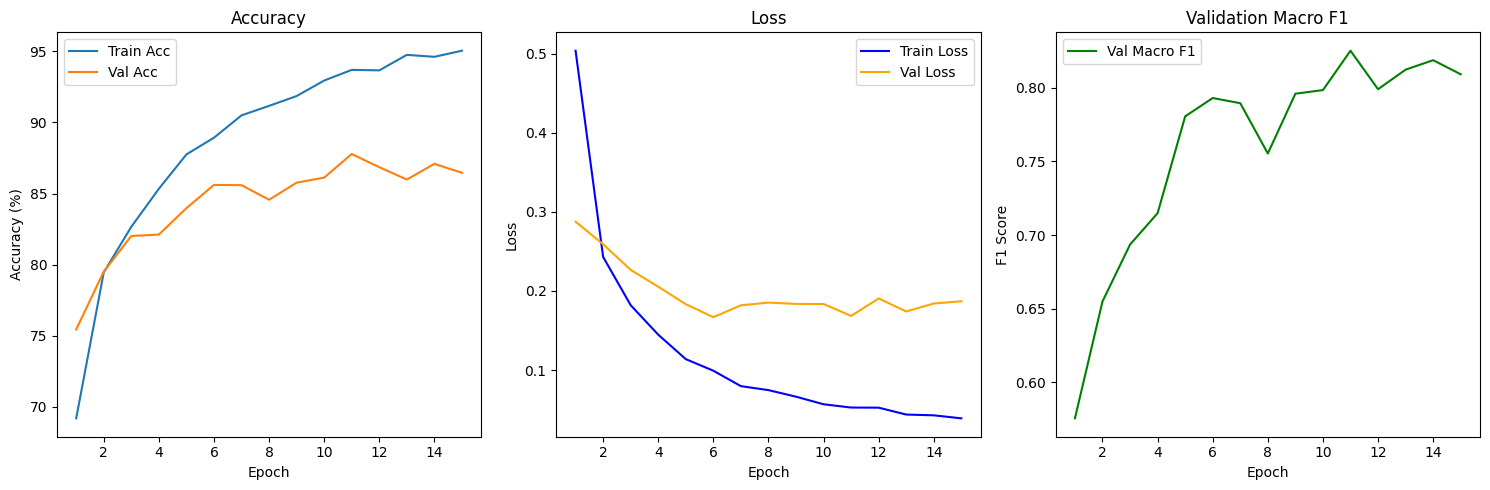

In [ ]:

# === Plotting After Training ===
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(15, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 3, 2)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Macro F1
plt.subplot(1, 3, 3)
plt.plot(epochs, val_f1s, label='Val Macro F1', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation Macro F1')
plt.legend()

plt.tight_layout()
plt.show()


## Validation Conf Matrix:

Final Validation Accuracy: 85.61%


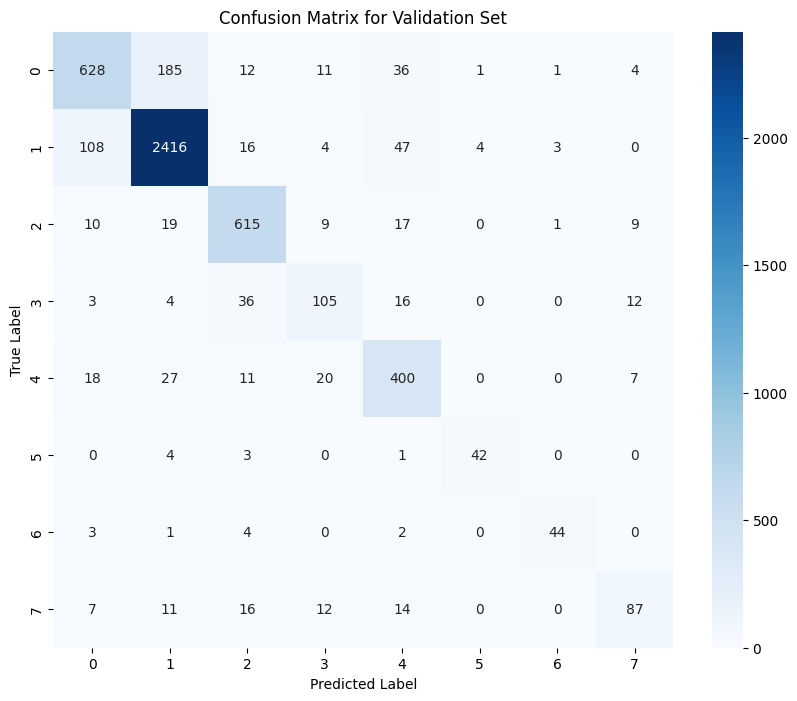

In [ ]:
# Load the trained model
model.load_state_dict(torch.load('best_vit_model_lowest_loss.pth'))

# Assuming 'val_loader' is your DataLoader for the validation dataset
# If you don't have 'val_loader', replace it with your actual validation DataLoader
# Example:
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

def evaluate(model, dataloader, criterion=None, is_test=False):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    all_probs = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=-1)

            if is_test:
                max_probs, predicted = probs.max(1)
                unk_probs = 1 - max_probs
                predicted = torch.where(unk_probs > 0.5,
                                        torch.tensor(num_classes-1).to(device),
                                        predicted)
            else:
                _, predicted = probs.max(1)

            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    if criterion is not None:
        return 100. * correct / total, all_preds, all_labels, all_probs
    else:
        return 100. * correct / total, all_preds, all_labels, all_probs

# Evaluate the model on the validation set
final_val_acc, val_preds, val_labels, _ = evaluate(model, val_loader, criterion=None)

# Print final validation accuracy
print(f'Final Validation Accuracy: {final_val_acc:.2f}%')

# Compute confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Val Acc was: 86.19

# Testing:

## Evaluation without UNK

In [ ]:
transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.Rotate90(angles=[0, 90, 180, 270]),
    ]
)


In [ ]:

tta_transforms = [
    T.Compose([T.RandomRotation(degrees=10)]),            # Rotate by up to 30 degrees
    #T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2)]),  # Color jitter
    #T.Compose([T.Resize((224, 224))]),
]



def tta_predict(model, inputs):
    """Applies TTA and averages the predictions."""
    tta_preds = []
    for tta_transform in tta_transforms:
        augmented_inputs = torch.stack([tta_transform(img.cpu()) for img in inputs])  # Apply transform individually
        augmented_inputs = augmented_inputs.to(device)
        outputs = model(augmented_inputs)
        probs = outputs.softmax(dim=-1)
        tta_preds.append(probs)
    avg_probs = torch.mean(torch.stack(tta_preds), dim=0)
    return avg_probs

def evaluate_ignore_unk_with_tta(model, dataloader):
    """
    Evaluates the model on test set, ignoring UNK class, with TTA applied.
    """
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    all_probs = []
    misclassified_images = []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Evaluating with TTA"):  # <-- tqdm added here
            inputs, targets = inputs.to(device), targets.to(device)

            # Skip samples labeled as UNK (class 8)
            mask = targets != 8
            if not mask.any():
                continue

            # Filter out UNK samples
            filtered_inputs = inputs[mask]
            filtered_targets = targets[mask]

            if len(filtered_inputs) == 0:
                continue

            # Apply TTA prediction
            probs = tta_predict(model, filtered_inputs)

            # Only consider probabilities for known classes (0-7)
            known_probs = probs[:, :8]
            _, predicted = known_probs.max(1)

            correct += predicted.eq(filtered_targets).sum().item()
            total += filtered_targets.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(filtered_targets.cpu().numpy())
            all_probs.extend(known_probs.cpu().numpy())

            # Collect misclassified images for visualization
            for i in range(len(filtered_targets)):
                if predicted[i] != filtered_targets[i]:
                    misclassified_images.append((filtered_inputs[i].cpu(), predicted[i].cpu(), filtered_targets[i].cpu()))

    accuracy = 100. * correct / total if total > 0 else 0
    return accuracy, all_preds, all_labels, all_probs, misclassified_images

In [ ]:
def evaluate_ignore_unk(model, dataloader, device): # Without TTA
    """
    Evaluates the model on test set, ignoring samples that are labeled as UNK class.
    Works with a model trained on 9 classes but only evaluates on the first 8 classes.
    """
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    all_probs = []
    misclassified_images = []

    with torch.no_grad():
        # Wrap dataloader with tqdm for progress bar
        for inputs, targets in tqdm(dataloader, desc="Evaluating", ncols=100):
            inputs, targets = inputs.to(device), targets.to(device)

            # Skip samples labeled as UNK (class 8)
            mask = targets != 8
            if not mask.any():
                continue

            # Filter out UNK samples
            filtered_inputs = inputs[mask]
            filtered_targets = targets[mask]

            if len(filtered_inputs) == 0:
                continue

            outputs = model(filtered_inputs)
            probs = outputs.softmax(dim=-1)

            # Only consider probabilities for known classes (0-7)
            known_probs = probs[:, :8]
            _, predicted = known_probs.max(1)

            correct += predicted.eq(filtered_targets).sum().item()
            total += filtered_targets.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(filtered_targets.cpu().numpy())
            all_probs.extend(known_probs.cpu().numpy())

            # Collect misclassified images for visualization
            for i in range(len(filtered_targets)):
                if predicted[i] != filtered_targets[i]:
                    misclassified_images.append((filtered_inputs[i].cpu(), predicted[i].cpu(), filtered_targets[i].cpu()))

    accuracy = 100. * correct / total if total > 0 else 0
    return accuracy, all_preds, all_labels, all_probs, misclassified_images


Evaluating on test set (ignoring UNK class, with TTA)...


Evaluating with TTA: 100%|████████████████████| 258/258 [04:44<00:00,  1.10s/it]


Test Accuracy (excluding UNK): 73.80%
F1 Score (excluding UNK): 0.7366


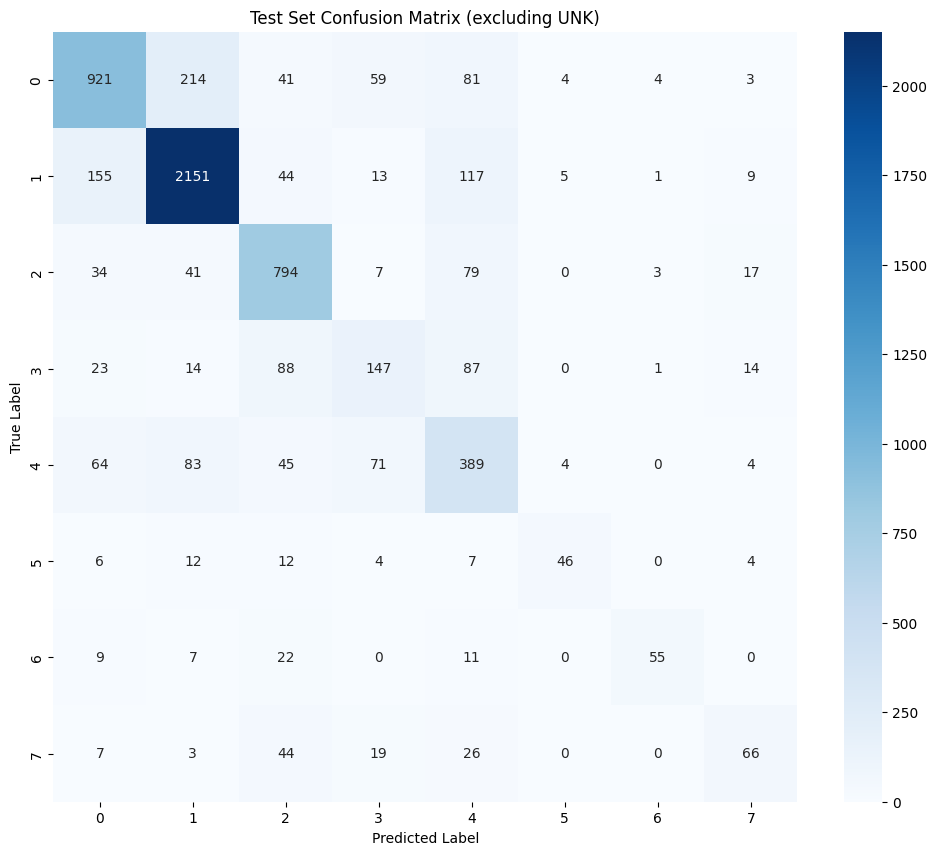

Displaying first 1622 misclassified images:


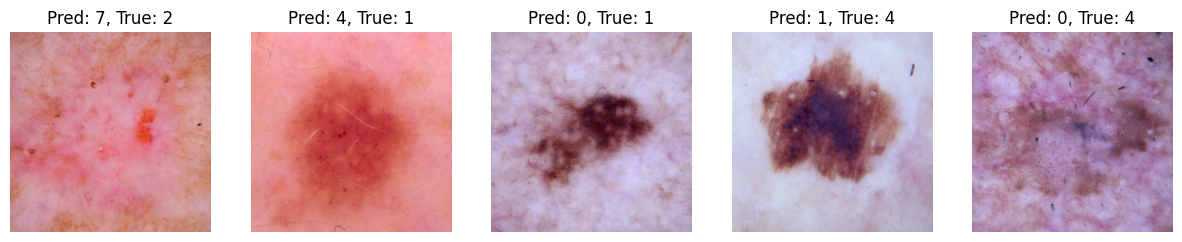

NameError: name 'test_ground_truth_df' is not defined

In [ ]:

"""
# ---------------
# FOR TESTING ONLY
num_classes = 8
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
model = model.to(device)
# ---------------

model.load_state_dict(torch.load('./Old Models/best_vit_model_7121.pth', map_location=device))
#model.load_state_dict(torch.load('./best_vit_model_after_val_71.64.pth', map_location=device))
"""
model = timm.create_model('efficientnet_b5', pretrained=True, num_classes=8).to(device)
model.load_state_dict(torch.load('./best_efficientnetb5_7363.pth', map_location=device))
model =  tta.ClassificationTTAWrapper(model, transforms)


# After training loop, evaluate ignoring UNK class
print("\nEvaluating on test set (ignoring UNK class, with TTA)...")
test_acc, test_preds, test_labels, test_probs, misclassified_images = evaluate_ignore_unk_with_tta(model, test_loader)
#test_acc, test_preds, test_labels, test_probs, misclassified_images = evaluate_ignore_unk(model, test_loader, device)
print(f'Test Accuracy (excluding UNK): {test_acc:.2f}%')

# Calculate F1 Score (weighted)
from sklearn.metrics import f1_score
f1 = f1_score(test_labels, test_preds, average='weighted')
print(f'F1 Score (excluding UNK): {f1:.4f}')

# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm_test = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Set Confusion Matrix (excluding UNK)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Misclassified images
print(f"Displaying first {len(misclassified_images)} misclassified images:")
num_images = 5  # Change if needed
plt.figure(figsize=(15, 10))

for i, (image, pred, true) in enumerate(misclassified_images[:num_images]):
    plt.subplot(1, num_images, i + 1)
    image = image.permute(1, 2, 0).cpu().numpy()

    if image.min() < 0 or image.max() > 1:
        image = (image - image.min()) / (image.max() - image.min())

    plt.imshow(image)
    plt.title(f"Pred: {pred}, True: {true}")
    plt.axis('off')

plt.show()
